# Import Packages

In [1]:
# data preprocessing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

# deep learning modules
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPool2D, Dense, Input, Flatten
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

# data loading modules
from keras.utils import image_dataset_from_directory, load_img, img_to_array

# Image related modules
from PIL import Image

from pathlib import Path

2024-05-19 11:14:29.138644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 11:14:29.138735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 11:14:29.234128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preprocessing

In [2]:
# paths of the training and test datasets

train_path = Path("/kaggle/input/emotion-detection-fer/train")

test_path = Path("/kaggle/input/emotion-detection-fer/test")

In [3]:
import os

## Class Names

In [4]:
# get all the class names

class_names = []

for files in train_path.iterdir():
    class_names.append(files.stem)

class_names

['fearful', 'disgusted', 'angry', 'neutral', 'sad', 'surprised', 'happy']

## Prepare Directories into train and test

In [5]:
# all the filenames from all the directories
train_filenames = {}

for files in train_path.iterdir():
    train_filenames[files.stem] = {'filenames': [filename for filename in files.iterdir()],
                                   'count': len([filename for filename in files.iterdir()])}

In [6]:
test_filenames = {}

for files in test_path.iterdir():
    test_filenames[files.stem] = {'filenames': [filename for filename in files.iterdir()],
                                   'count': len([filename for filename in files.iterdir()])}

## Make the class distribution

In [7]:
# file count

class_dist = {key:train_filenames[key]['count'] for key in train_filenames}

class_dist

{'fearful': 4097,
 'disgusted': 436,
 'angry': 3995,
 'neutral': 4965,
 'sad': 4830,
 'surprised': 3171,
 'happy': 7215}

<Axes: >

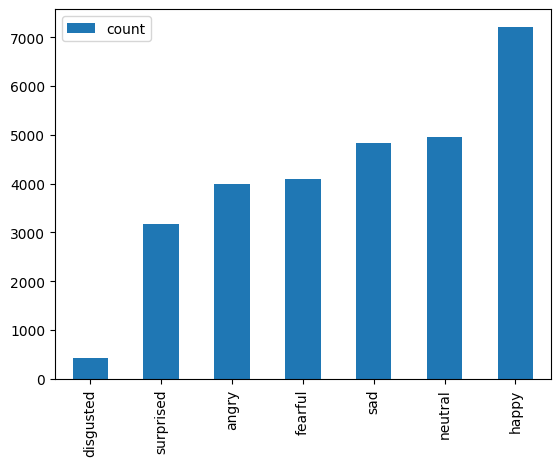

In [8]:
# make a bar chart of class dist

pd.DataFrame(class_dist,index=['count']).T.sort_values(by='count').plot(kind='bar')

In [9]:
len(class_names)

7

In [10]:
from math import ceil
from random import choice

# Plot Sample Images

In [11]:
def plot_image_each_category():
    num_of_classes = len(class_names)
    num_of_rows = ceil(num_of_classes / 4)
    num_of_cols = 4
    fig = plt.figure(figsize=(10,10))
    for ind in range(num_of_classes):
        # read a random file from directory
        random_filename = choice(train_filenames[class_names[ind]]['filenames'])
        plt.subplot(num_of_rows,num_of_cols,ind+1)
        img = Image.open(random_filename)
        plt.imshow(img,cmap='gray')
        plt.title(f'Emotion = {class_names[ind]}')
        plt.axis('off')

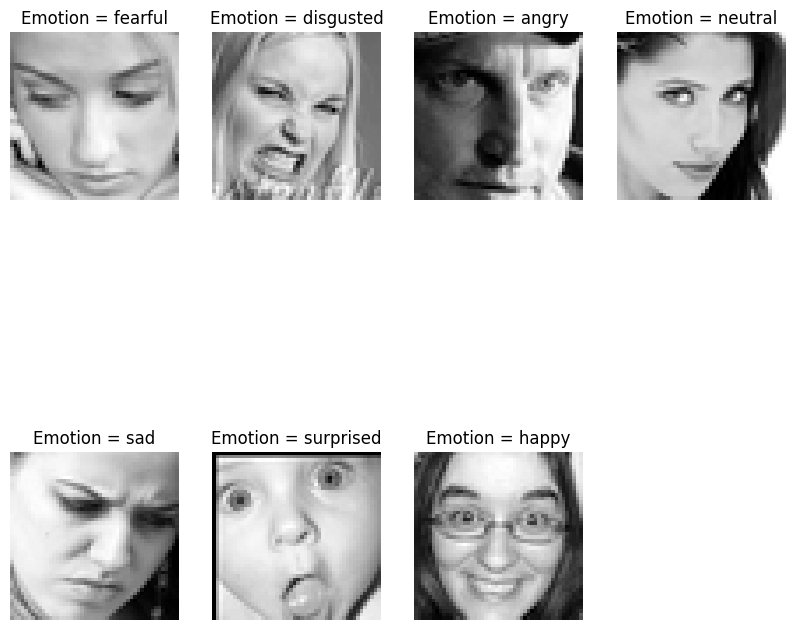

In [12]:
plot_image_each_category()

# Data Validation

In [13]:
from collections import Counter

## Validate File Extensions

In [14]:
# validate the extensions of all images

def check_image_extensions(filenames):
    for class_name in class_names:
        counts = Counter(f.suffix for f in filenames[class_name]['filenames'])
        print(f'For emotion {class_name.upper()} the file extensions are {counts}')

In [15]:
train_filenames['disgusted']['filenames'][0].suffix

'.png'

In [16]:
# check file extensions for training data

check_image_extensions(train_filenames)

For emotion FEARFUL the file extensions are Counter({'.png': 4097})
For emotion DISGUSTED the file extensions are Counter({'.png': 436})
For emotion ANGRY the file extensions are Counter({'.png': 3995})
For emotion NEUTRAL the file extensions are Counter({'.png': 4965})
For emotion SAD the file extensions are Counter({'.png': 4830})
For emotion SURPRISED the file extensions are Counter({'.png': 3171})
For emotion HAPPY the file extensions are Counter({'.png': 7215})


In [17]:
# check file extensions for test data

check_image_extensions(test_filenames)

For emotion FEARFUL the file extensions are Counter({'.png': 1024})
For emotion DISGUSTED the file extensions are Counter({'.png': 111})
For emotion ANGRY the file extensions are Counter({'.png': 958})
For emotion NEUTRAL the file extensions are Counter({'.png': 1233})
For emotion SAD the file extensions are Counter({'.png': 1247})
For emotion SURPRISED the file extensions are Counter({'.png': 831})
For emotion HAPPY the file extensions are Counter({'.png': 1774})


## Validate File loading

In [18]:
# validate file reads

def validate_files(filenames):
    for class_name in class_names:
        paths = filenames[class_name]['filenames']
        for path in paths:
            try:
                img = Image.open(path)
            except Exception as e:
                print(f'Could not open the file {path}')
                os.remove(path)

In [19]:
# validate the training files

#validate_files(train_filenames)

In [20]:
# validate the test files

#validate_files(test_filenames)

# Handle Class Imbalance

In [21]:
class_dist_df = pd.DataFrame(class_dist,index=['count']).T

class_dist_df['weights'] = (class_dist_df['count'].sum() / class_dist_df['count']) / 10

class_dist_df

,count,weights
fearful,4097,0.700732
disgusted,436,6.584633
angry,3995,0.718623
neutral,4965,0.578228
sad,4830,0.594389
surprised,3171,0.905361
happy,7215,0.397907


In [22]:
# adjust the class weights to solve imbalance dataset problem
class_weights = class_dist_df['weights'].values

class_weights

array([0.70073224, 6.58463303, 0.71862328, 0.57822759, 0.59438923,
       0.90536108, 0.39790714])

In [23]:
# read an image to check size

plt.imread(train_filenames['sad']['filenames'][10]).shape

(48, 48)

# Load the train and test data into Data Generator

In [24]:
BATCH_SIZE = 32
IMG_WIDTH = 48
IMG_HEIGHT = 48

In [25]:
# create the train and test datasets

train_dataset = image_dataset_from_directory(directory=train_path,
                                             class_names=class_names,
                                             color_mode='grayscale',
                                             batch_size=BATCH_SIZE,
                                             image_size=(48,48),
                                             seed=42)

test_dataset = image_dataset_from_directory(directory=test_path,
                                             class_names=class_names,
                                             color_mode='grayscale',
                                             batch_size=BATCH_SIZE,
                                             image_size=(48,48),
                                             seed=42)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


# Model

## Build the model architecture

In [26]:
from keras.layers import Rescaling

In [27]:
from keras.layers import BatchNormalization
from keras.layers import Dropout

In [28]:
# build the neural network

model = Sequential()

# input layer
model.add(Input(shape=(48,48,1)))


# rescale the images
model.add(Rescaling(scale=1./255))

# first convolution layer with pooling
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# second convolution layer with pooling
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# third convolution layer with pooling
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# fourth convolution layer with pooling
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

# add flatten layer
model.add(Flatten())

# create fully connected layers
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(rate=0.2))

# create the output layer
model.add(Dense(units=7,activation='softmax'))

### Generate model summary

In [29]:
# generate model summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 512)    │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,79

 Total params: 6,551,559 (24.99 MB)

 Trainable params: 6,549,255 (24.98 MB)

 Non-trainable params: 2,304 (9.00 KB)

### Plot Model Architecture

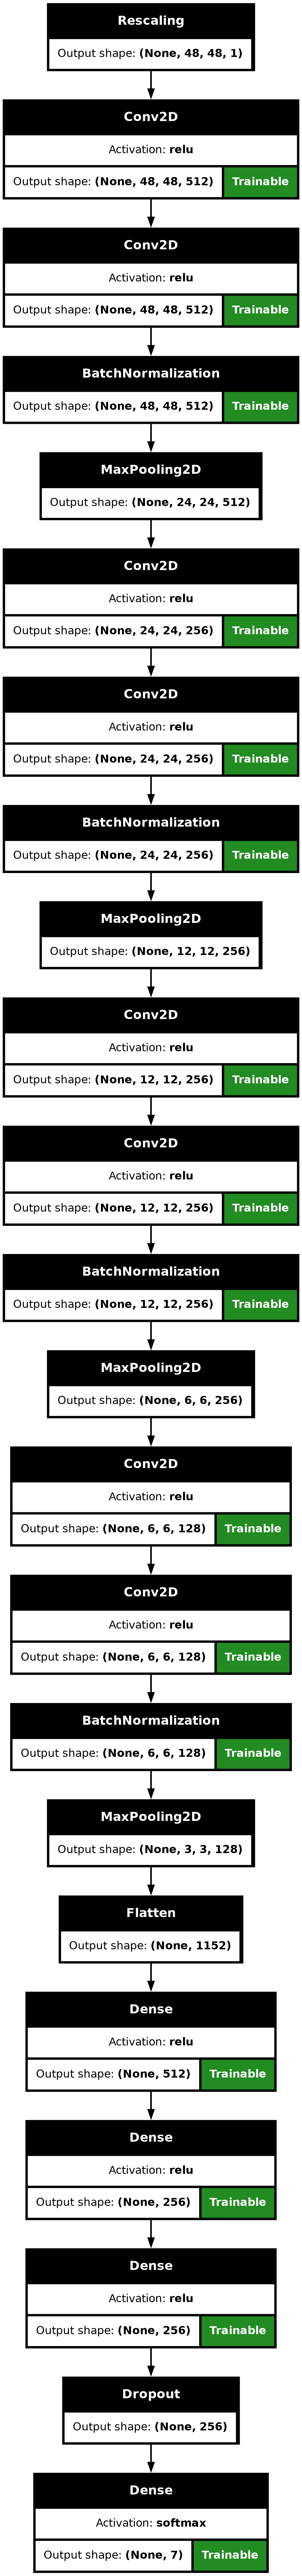

In [30]:
# plot the model

plot_model(model,show_shapes=True,show_layer_activations=True,show_trainable=True)

## Model Compilation

In [31]:
pwd

'/kaggle/working'

In [32]:
from pathlib import Path
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [33]:
# model checkpoint callback

save_filepath ="/kaggle/working/model-checkpoint/"
Path(save_filepath).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    ModelCheckpoint(
        filepath="/kaggle/working/model-checkpoint/{epoch:02d}-{val_loss:.2f}.keras" ,
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch",
        initial_value_threshold=None,
    ),
    EarlyStopping(monitor="val_loss",
                  min_delta=0.1,
                  patience=5,
                  verbose=1,
                  mode='min',
                  restore_best_weights=True),
#     ReduceLROnPlateau(factor=0.1,
#                      patience=2,
#                      verbose=1,
#                      min_delta=0.1)
]

[x.__class__.__name__ for x in my_callbacks]

['ModelCheckpoint', 'EarlyStopping']

In [34]:
from keras.optimizers import Adam

In [35]:
# compile the model

model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
class_dist_df

,count,weights
fearful,4097,0.700732
disgusted,436,6.584633
angry,3995,0.718623
neutral,4965,0.578228
sad,4830,0.594389
surprised,3171,0.905361
happy,7215,0.397907


In [37]:
class_weights_model = {k:v for k,v in zip(range(7),class_weights)}

class_weights_model

{0: 0.7007322431047107,
 1: 6.584633027522936,
 2: 0.7186232790988736,
 3: 0.5782275931520645,
 4: 0.5943892339544513,
 5: 0.9053610848312836,
 6: 0.3979071379071379}

## Model Training

In [38]:
from warnings import filterwarnings

filterwarnings('ignore')


In [39]:
# # fit on the training data

# history = model.fit(train_dataset, epochs=3,
#                     validation_data=test_dataset,
#                     class_weight=class_weights_model,
#                     callbacks=my_callbacks)

In [40]:
# history = history.history

In [41]:
# # plot the accuracy curves

# plt.plot(history['accuracy'],label='train_accuracy')
# plt.plot(history['val_accuracy'],label='validation_accuracy')
# plt.legend()
# plt.show()

In [42]:
# from keras.saving import save_model


# save_model_path = Path("/kaggle/working/model/")

# save_model_path.mkdir(exist_ok=True)

# save_model(model=model,
#           filepath=save_model_path / "model_ver_3.keras")

## ResNet 101 V2

In [180]:
from keras.applications import ResNet50V2

In [181]:
# create the train and test datasets

train_dataset = image_dataset_from_directory(directory=train_path,
                                             class_names=class_names,
                                             color_mode='rgb',
                                             batch_size=BATCH_SIZE,
                                             image_size=(48,48),
                                             seed=42)

test_dataset = image_dataset_from_directory(directory=test_path,
                                             class_names=class_names,
                                             color_mode='rgb',
                                             batch_size=BATCH_SIZE,
                                             image_size=(48,48),
                                             seed=42)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [182]:
# add fully connected layer

dense_1 = Dense(units=64,activation='relu',kernel_regularizer='l2',bias_regularizer='l2')
dense_2 = Dense(units=32,activation='relu',kernel_regularizer='l2',bias_regularizer='l2')
dense_3 = Dense(units=16,activation='relu',kernel_regularizer='l2',bias_regularizer='l2')
dropout = Dropout(rate=0.2)

In [183]:
    resnet = ResNet50V2(include_top=False,
                    input_shape=(48,48,3))

In [184]:
# make the last 50 layers as trainable and rest non-trainable

for layer in resnet.layers[:-50]:
    layer.trainable = False


In [185]:
resnet.inputs

[<KerasTensor shape=(None, 48, 48, 3), dtype=float32, sparse=None, name=keras_tensor_4128>]

In [186]:
resnet.output

<KerasTensor shape=(None, 2, 2, 2048), dtype=float32, sparse=False, name=keras_tensor_4317>

In [187]:
# input layer
input_layer = Input(shape=(48,48,3))


# rescale the images
rescale_layer = Rescaling(scale=1./255)(input_layer)

# resnet model
resnet_model = resnet(rescale_layer)
resnet_dropout = Dropout(rate=0.3)(resnet_model)

# dense layers
flatten_layer = Flatten()(resnet_dropout)

fc_layer_1 = dense_1(flatten_layer)
fc_layer_2 = dense_2(fc_layer_1)
fc_layer_3 = dense_3(fc_layer_2)

dropout_fc = Dropout(rate=0.35)(fc_layer_1)
output_layer = Dense(units=7,activation='softmax')(dropout_fc)

In [188]:
final_model = Model(inputs=input_layer,outputs=output_layer)

final_model.summary()

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2, 2, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 2, 2, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,089,607 (91.89 MB)

 Trainable params: 16,877,063 (64.38 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

In [189]:
# compile the model
final_model.compile(optimizer=Adam(learning_rate=0.000005), loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [190]:
# model checkpoint callback

save_filepath ="/kaggle/working/resnet/"
Path(save_filepath).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    ModelCheckpoint(
        filepath="/kaggle/working/resnet/model.keras" ,
        monitor="loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch",
        initial_value_threshold=None,
    ),
#     EarlyStopping(monitor="val_loss",
#                   min_delta=0.1,
#                   patience=30,
#                   verbose=1,
#                   mode='min',
#                   restore_best_weights=True),
#     ReduceLROnPlateau(factor=0.1,
#                      patience=2,
#                      verbose=1,
#                      min_delta=0.3)
]

[x.__class__.__name__ for x in my_callbacks]

['ModelCheckpoint']

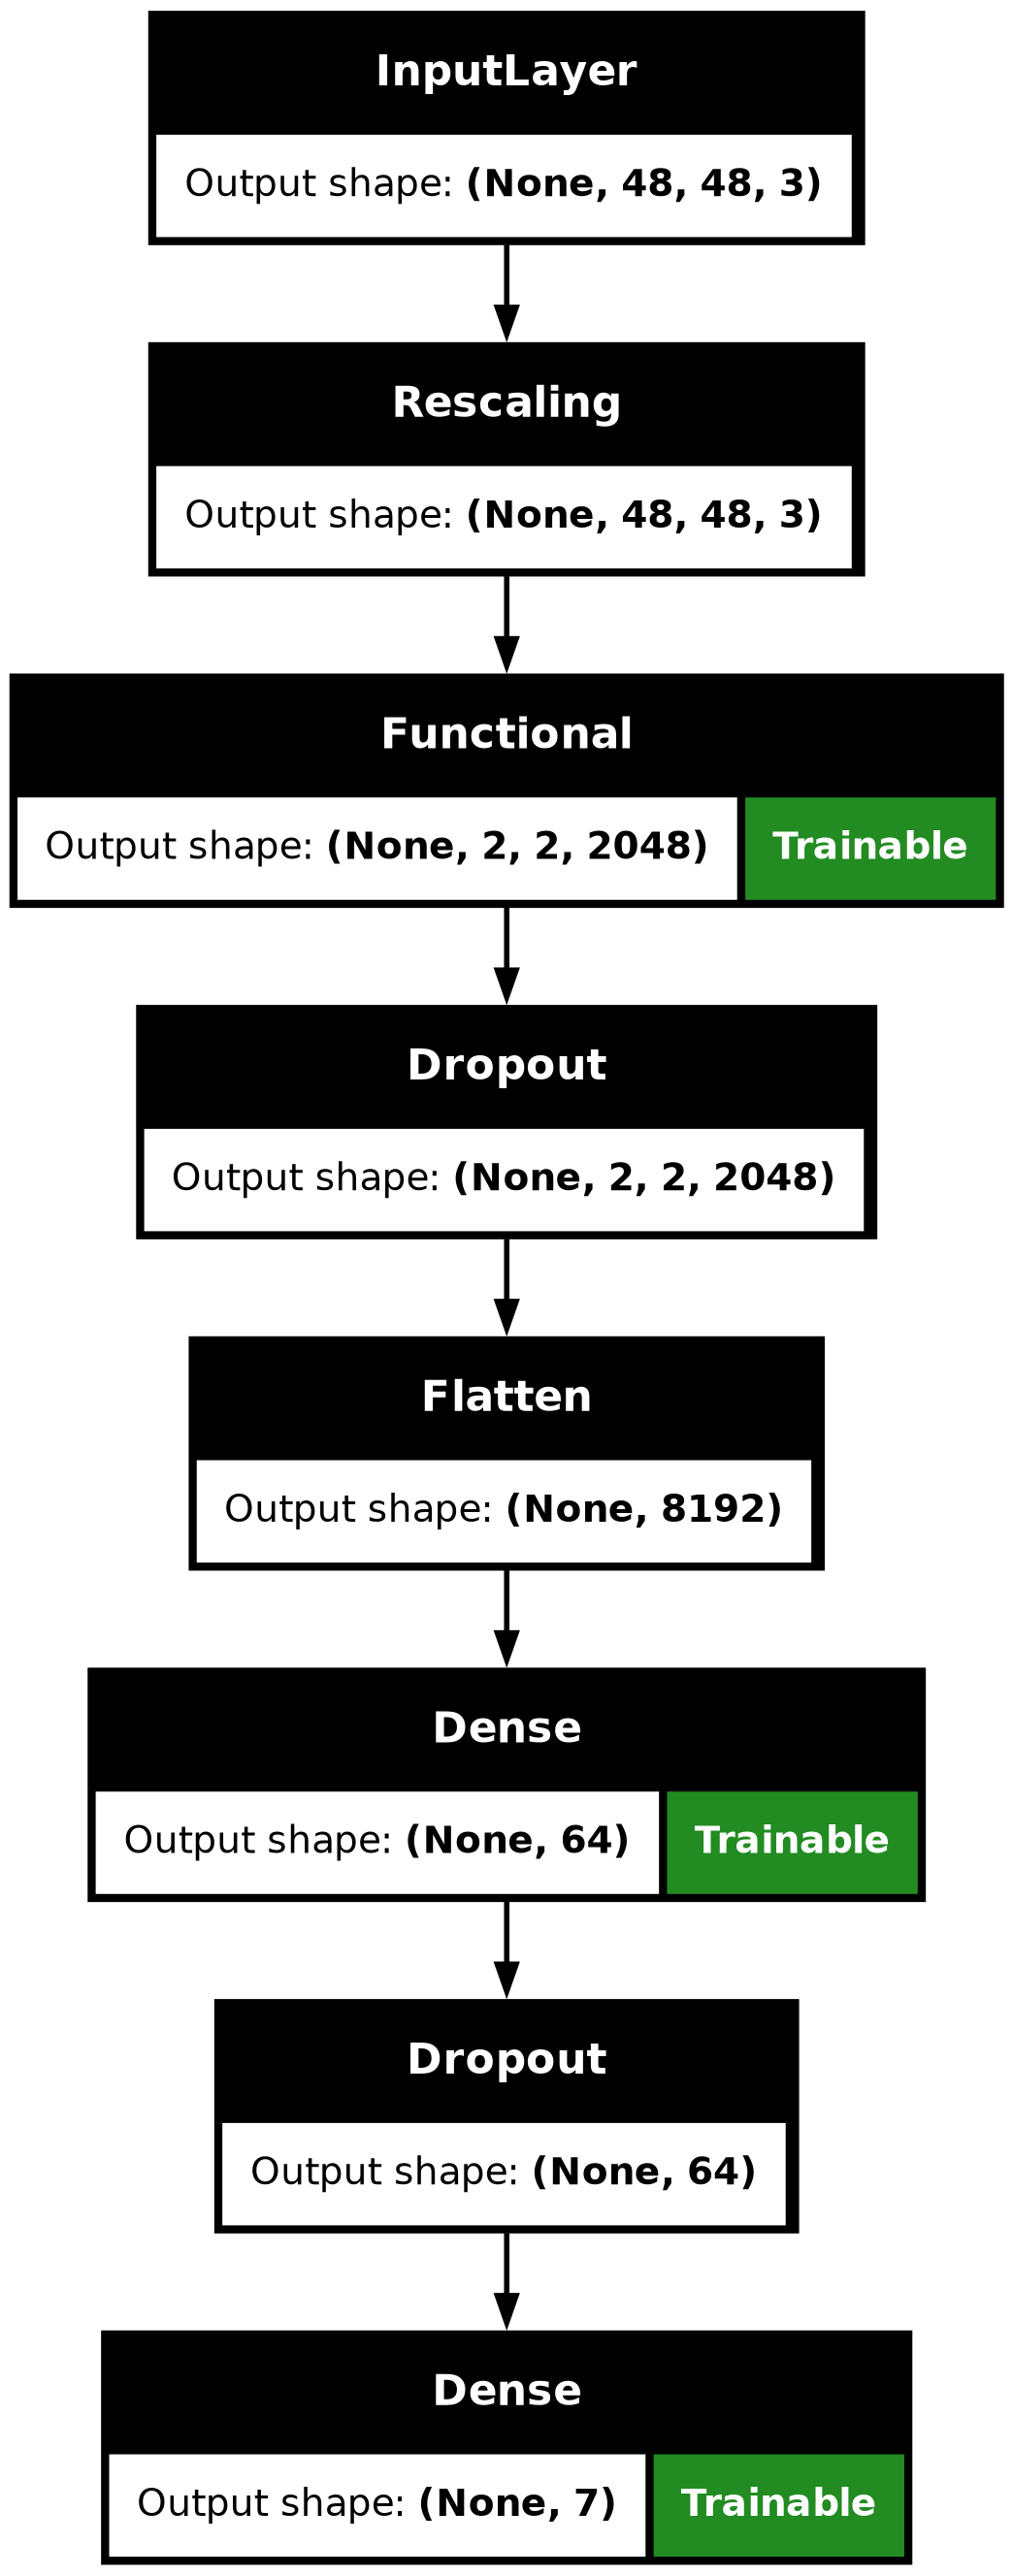

In [191]:
# plot the model

plot_model(model=final_model,
          show_shapes=True,
          show_trainable=True)

In [192]:
# fit the resnet model with epochs = 30

history = final_model.fit(train_dataset, epochs=100,
                          validation_data=test_dataset,
                          class_weight=class_weights_model,
                          callbacks=my_callbacks)

Epoch 1/100
  5/898 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.1826 - loss: 4.0132 

W0000 00:00:1716130678.495525      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1505 - loss: 3.3315

W0000 00:00:1716130710.677364      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716130714.186853      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: loss improved from inf to 3.15992, saving model to /kaggle/working/resnet/model.keras


W0000 00:00:1716130718.250615      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 46ms/step - accuracy: 0.1505 - loss: 3.3313 - val_accuracy: 0.1716 - val_loss: 3.4198
Epoch 2/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1624 - loss: 2.8765
Epoch 2: loss improved from 3.15992 to 2.79633, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.1624 - loss: 2.8764 - val_accuracy: 0.1903 - val_loss: 3.1877
Epoch 3/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1795 - loss: 2.6410
Epoch 3: loss improved from 2.79633 to 2.60277, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.1795 - loss: 2.6409 - val_accuracy: 0.1985 - val_loss: 3.0577
Epoch 4/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1819 - loss: 2.5141
Epoch 4: loss improved from 2.60277 to 2.48153, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.1819 - loss: 2.5140 - val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



896/898 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9593 - loss: 0.2429
Epoch 85: loss improved from 0.24191 to 0.23782, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9593 - loss: 0.2429 - val_accuracy: 0.5092 - val_loss: 2.8377
Epoch 86/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9620 - loss: 0.2328
Epoch 86: loss improved from 0.23782 to 0.22919, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9620 - loss: 0.2328 - val_accuracy: 0.5095 - val_loss: 2.8181
Epoch 87/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9629 - loss: 0.2248
Epoch 87: loss improved from 0.22919 to 0.22158, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9629 - loss: 0.2248 - val_accuracy: 0.5102 - val_loss: 2.8445
Epoch 88/100
896/898 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9666 - loss: 0.2136


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9732 - loss: 0.1756
Epoch 95: loss improved from 0.17614 to 0.17362, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9732 - loss: 0.1756 - val_accuracy: 0.5071 - val_loss: 2.8711
Epoch 96/100
896/898 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9775 - loss: 0.1503
Epoch 99: loss improved from 0.16057 to 0.15060, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9775 - loss: 0.1503 - val_accuracy: 0.5100 - val_loss: 2.8898
Epoch 100/100
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9772 - loss: 0.1473
Epoch 100: loss improved from 0.15060 to 0.14549, saving model to /kaggle/working/resnet/model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.9772 - loss: 0.1473 - val_accuracy: 0.5092 - val_loss: 2.8954


In [193]:
# evaluate the model

final_model.evaluate(train_dataset)

898/898 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9968 - loss: 0.1111


W0000 00:00:1716133392.659091      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.1103820726275444, 0.9972482323646545]

In [194]:
final_model.evaluate(test_dataset)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5166 - loss: 2.8838


[2.895353317260742, 0.5091947913169861]

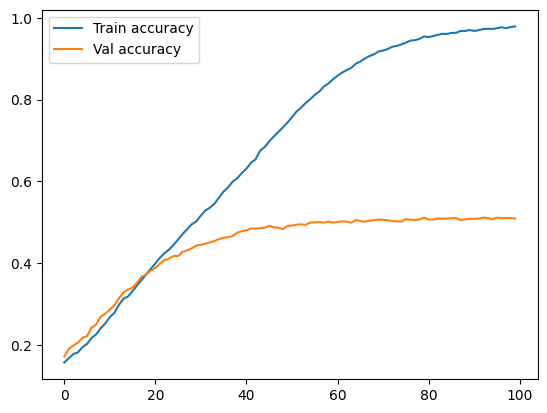

In [195]:
# do the plotting of accuracy

plt.plot(history.history['accuracy'],label='Train accuracy')
plt.plot(history.history['val_accuracy'],label='Val accuracy')
plt.legend()
plt.show()

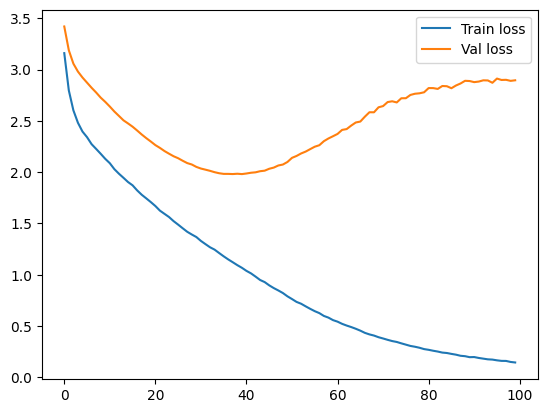

In [196]:
# do the plotting of loss

plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Val loss')
plt.legend()
plt.show()